In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.inference import DBNInference

from models.model_v0 import DumbDiscretizer, pgmpy_friendly_transformer, CustomDBNInference

c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# I. General settings

In [28]:
# load data parameters 
countries = ['France', 'Germany', 'United Kingdom', 'Italy', 'Spain', 'Japan', 
             'Sweden', 'Switzerland', 'Belgium', 'Australia', 'Austria', 'China', 
             'Croatia', 'Finland', 'Greece', 'India', 'New Zealand', 
             'Russia']
columns = ['year', 'population', 'gdp', 'energy_per_capita', 'country']

# preprocessing parameters
split_year = 2009  # trainset until split_year
test_country = "United Kingdom"
sliding_window = 2
# define discretization strategy
nb_classes = {  # nb of classes for each variable
    "gdp_per_capita_stationary": 10,  
    "population_stationary": 10, 
    "energy_cons_stationary": 5
}

# model parameters


# II. Load data

### Load raw data 

In [8]:
all_data = pd.read_csv("data/WorldEnergyConsumption.csv")
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22012 entries, 0 to 22011
Columns: 129 entries, country to wind_share_energy
dtypes: float64(126), int64(1), object(2)
memory usage: 21.7+ MB


### Select columns

In [9]:
data = all_data[columns]
data.describe()

,year,population,gdp,energy_per_capita
count,22012.000000,1.812300e+04,1.111300e+04,10602.000000
mean,1974.213247,1.053096e+08,3.585114e+11,25742.760033
std,35.058653,4.640460e+08,2.411179e+12,36122.506628
min,1900.000000,1.833000e+03,1.642060e+08,0.000000
25%,1946.000000,1.712404e+06,1.365898e+10,3101.076250
50%,1984.000000,6.991543e+06,4.167411e+10,13597.986000
75%,2003.000000,2.557688e+07,1.744295e+11,36847.052500
max,2022.000000,7.975105e+09,1.136302e+14,657539.188000


### Select countries

In [11]:
data = data.loc[data.country.isin(countries)]
data.dropna(inplace=True)  # drop all nan values
data.sample(5)

,year,population,gdp,energy_per_capita,country
4901,1990,4873705.0,5.837408e+10,20686.525,Croatia
2398,2012,11031140.0,4.211009e+11,62090.016,Belgium
7758,1977,78221280.0,1.628636e+12,51228.902,Germany
16940,2017,145452544.0,3.524075e+12,55974.684,Russia
4927,2016,4223748.0,8.023019e+10,22428.080,Croatia


In [12]:
# rescale data 
data['gdp'] /= 1e12
data['population'] /= 1e7

# create gdp_per_capita and energy_cons

data['gdp_per_capita'] = data['gdp']/data['population']
data['energy_cons'] = data['energy_per_capita']*data['population']

# III. Preprocessing 

### Stationarization 

Fonction permettant de stationariser les time series:

In [17]:
def stationarize(input_df: pd.DataFrame):
    """
    Given data corresponding to only one country, 
    create new columns for time series stationarization.

    :params input_df: pd.DataFrame
        Dataframe of a ocuntry with at least gdp, energy_per_capita and 
        population columns 

    :return pd.DataFrame
    """
    # copy input dataframe 
    df = input_df.copy()

    # stationarisation of gdp 
    df['log_gdp'] = df['gdp_per_capita'].apply(lambda x: np.log(x))
    df['gdp_order_1'] = df['log_gdp'] - df['log_gdp'].shift()
    df['gdp_per_capita_stationary'] = df['gdp_order_1'] - df['gdp_order_1'].shift()

    # stationarization of energy consumption per capita
    df['log_energy'] = df['energy_cons'].apply(lambda x: np.log(x))
    df['energy_cons_order_1'] = df['log_energy'] - df['log_energy'].shift()
    df['energy_cons_stationary'] = df['energy_cons_order_1'] - df['energy_cons_order_1'].shift()
    
    # stationarization of population
    df['log_pop'] = df['population'].apply(lambda x: np.log(x))
    df['population_order_1'] = df['log_pop'] - df['log_pop'].shift()
    df['population_stationary'] = df['population_order_1'] - df['population_order_1'].shift()

    # new create columns 
    new_columns = [
        "gdp_per_capita_stationary", 
        "energy_cons_stationary",
        "population_stationary"
    ]

    # old columns to keep 
    old_cols = ["country", "year"]

    return df[new_columns + old_cols]

In [18]:
# stationarize data 
for i, country in enumerate(countries):
    df_country = stationarize(data[data.country == country])

    if i == 0:
        df_stationary = df_country
    else:
        df_stationary = pd.concat([df_stationary, df_country])

df_stationary.sample(10)

,gdp_per_capita_stationary,energy_cons_stationary,population_stationary,country,year
9281,0.006131,-0.031204,-0.000526,India,2015
18845,0.027315,0.097836,0.000813,Switzerland,1985
1620,-0.022315,-0.006896,0.002204,Australia,2008
7222,0.006900,0.031352,-0.000148,Finland,2013
20552,0.003038,-0.029044,0.000448,United Kingdom,1987
9977,0.034142,-0.004810,0.000412,Italy,1973
18404,0.015102,-0.045744,-0.003844,Spain,2013
7201,0.027002,-0.026243,0.000161,Finland,1992
10166,-0.019893,-0.000068,0.000070,Japan,1997
16938,-0.052603,-0.018987,0.000376,Russia,2015


Nous devons analyser pourquoi des NaN se glissent dans le dataframe à cette étape (j'y reviens plus tard)

In [19]:
df_stationary[df_stationary.isna()].shape[0]

927

### Train-Test split 

In [20]:
df_test = df_stationary.loc[(df_stationary.country == test_country)
                            & (df_stationary.year> split_year)]
df_train = df_stationary[~df_stationary.index.isin(df_test.index)]

print(f"Train size: {df_train.shape[0]}")
print(f"Test size: {df_test.shape[0]}")

Train size: 918
Test size: 9


In [21]:
df_train.dropna(inplace=True)

C:\Users\victo\AppData\Local\Temp\ipykernel_23860\370300940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.dropna(inplace=True)


### Discretization 

In [22]:
print(f"{df_train[~df_train.isna()].shape[0]} rows without NaN")

882 rows without NaN


In [24]:
df_train

,gdp_per_capita_stationary,energy_cons_stationary,population_stationary,country,year
7299,-0.003909,0.038158,-4.363084e-04,France,1967
7300,-0.001252,-0.007915,-7.560240e-04,France,1968
7301,0.024484,0.043035,-6.086927e-04,France,1969
7302,-0.011263,-0.014586,-1.414622e-04,France,1970
7303,-0.008498,-0.043654,1.328581e-04,France,1971
...,...,...,...,...,...
16937,0.009681,0.014959,-2.964643e-07,Russia,2014
16938,-0.052603,-0.018987,3.757969e-04,Russia,2015
16939,0.026879,0.036117,3.890083e-04,Russia,2016
16940,0.018780,-0.014190,-6.784716e-04,Russia,2017


In [29]:
# define discretizer object 
discretizer = DumbDiscretizer(df_train, nb_classes=nb_classes)

# indexed dataframe 
df_index = discretizer.df

# print nb of NaN (must be investigated later) and dorp them
print(f"Nb of rows continaing NaN values: {df_index.isna().shape[1]}")
df_index.dropna(inplace=True)
df_index.sample(5)

Nb of rows continaing NaN values: 5


,gdp_per_capita_stationary,energy_cons_stationary,population_stationary,country,year
18402,5,2,4,Spain,2011
10174,5,2,4,Japan,2005
18753,5,2,5,Sweden,2016
1795,6,2,4,Austria,2018
1629,5,2,5,Australia,2017


### PGMPY friendly preprocessing

In [30]:
for i, country in enumerate(countries):

    # select country and relevant columns
    df_country = df_index[df_index.country == country]
    df_country = df_country.drop(["country", "year"], axis=1)
    
    print(f"Country: {country}", df_country.shape)

    # transform in a pgmpy friendly dataframe
    df_pgmpy_country = pgmpy_friendly_transformer(
        df=df_country, 
        sliding_window=sliding_window
    )
    df_pgmpy_country["country"] = country

    if i == 0:
        df_pgmpy = df_pgmpy_country
    else:
        df_pgmpy = pd.concat([df_pgmpy, df_pgmpy_country])

df_pgmpy.reset_index(inplace=True, drop=True)
df_pgmpy.sample(10)

Country: France (52, 3)
Country: Germany (52, 3)
Country: United Kingdom (43, 3)
Country: Italy (52, 3)
Country: Spain (52, 3)
Country: Japan (52, 3)
Country: Sweden (52, 3)
Country: Switzerland (52, 3)
Country: Belgium (52, 3)
Country: Australia (52, 3)
Country: Austria (52, 3)
Country: China (52, 3)
Country: Croatia (27, 3)
Country: Finland (52, 3)
Country: Greece (52, 3)
Country: India (52, 3)
Country: New Zealand (52, 3)
Country: Russia (32, 3)


,"(gdp_per_capita_stationary, 0)","(energy_cons_stationary, 0)","(population_stationary, 0)","(gdp_per_capita_stationary, 1)","(energy_cons_stationary, 1)","(population_stationary, 1)",country
448,6,2,4,8,3,4,Australia
131,6,3,5,5,3,5,United Kingdom
495,5,2,6,6,2,4,Austria
805,8,2,4,4,2,4,Russia
24,5,3,4,6,2,4,France
157,6,3,4,6,3,5,Italy
172,5,2,5,5,2,5,Italy
464,5,3,5,5,2,5,Australia
12,6,2,5,5,2,5,France
349,5,2,5,6,3,4,Switzerland


In [31]:
df_pgmpy[df_pgmpy.country == "France"].tail()

,"(gdp_per_capita_stationary, 0)","(energy_cons_stationary, 0)","(population_stationary, 0)","(gdp_per_capita_stationary, 1)","(energy_cons_stationary, 1)","(population_stationary, 1)",country
44,6,2,4,5,3,4,France
45,5,3,4,6,3,4,France
46,6,3,4,5,2,4,France
47,5,2,4,6,3,4,France
48,6,3,4,5,2,4,France


# Model 

### Training 

In [32]:
# build model 
dbn = DBN([
    (("gdp_per_capita_stationary", 0), ("energy_cons_stationary", 0)), 
    (("population_stationary", 0), ("energy_cons_stationary", 0)), 
    (("population_stationary", 0), ("population_stationary", 1)), 
    (("gdp_per_capita_stationary", 0), ("gdp_per_capita_stationary", 1))
])

In [33]:
dbn.fit(df_pgmpy.drop("country", axis=1))

# Inferences 

### Scenarios

In [34]:
length = df_test.shape[0]
col_evidence = ["population_stationary", "gdp_per_capita_stationary"]

scenario = {}
for col in col_evidence:
    new_evidence = {(col, i): df_test[df_test.year == split_year+i].iloc[0][col]
                    for i in range(1, length+1)}
    scenario.update(new_evidence)

In [35]:
df_test.head()

,gdp_per_capita_stationary,energy_cons_stationary,population_stationary,country,year
20575,0.062999,0.072826,0.000181,United Kingdom,2010
20576,-0.004081,-0.078831,0.000085,United Kingdom,2011
20577,-0.000841,0.073767,-0.000131,United Kingdom,2012
20578,0.006389,-0.019289,-0.000515,United Kingdom,2013
20579,0.011546,-0.053662,-0.000404,United Kingdom,2014


In [36]:
scenario

{('population_stationary', 1): 0.00018106985239807472,
 ('population_stationary', 2): 8.468730433119909e-05,
 ('population_stationary', 3): -0.00013097201121636814,
 ('population_stationary', 4): -0.0005148046793008731,
 ('population_stationary', 5): -0.000404062099745639,
 ('population_stationary', 6): -0.00036478203673984133,
 ('population_stationary', 7): -0.00035278557061335647,
 ('population_stationary', 8): -0.00036439184144509973,
 ('population_stationary', 9): -0.0006616720437833123,
 ('gdp_per_capita_stationary', 1): 0.06299920071361242,
 ('gdp_per_capita_stationary', 2): -0.004080783148634026,
 ('gdp_per_capita_stationary', 3): -0.0008406366818887179,
 ('gdp_per_capita_stationary', 4): 0.00638916999179151,
 ('gdp_per_capita_stationary', 5): 0.011546213931435512,
 ('gdp_per_capita_stationary', 6): -0.008017666747487051,
 ('gdp_per_capita_stationary', 7): -0.0031744135531707185,
 ('gdp_per_capita_stationary', 8): 0.0009472557045678842,
 ('gdp_per_capita_stationary', 9): -0.0047

In [37]:
# [discretizer.reverse_indexer(column_name="energy_per_capita_stationary", ind=i) 
#  for i in range(10)]

In [40]:
# use custom inference for model test
inference = CustomDBNInference(dbn, discretizer)

# provide evidence
evidence = {
    ("population_stationary", 0): df_train[(df_train.country==test_country)
                                           & (df_train.year == split_year)].iloc[0]["population_stationary"], 
    ("gdp_per_capita_stationary", 0): df_train[(df_train.country==test_country)
                                    & (df_train.year == split_year)].iloc[0]["gdp_per_capita_stationary"], 
}

scenario.update(evidence)

print("Evidence: ", scenario, "\n")

# now make a pred of Y at time t (now) till time t+horizon
pred_seq = inference.make_pred("energy_cons_stationary",
                               forecast_step=length+1, 
                               evidence=scenario, 
                               method="PM", 
                               verbose=False)

# get actual values model should have predicted 
actual_seq =  list(df_test.energy_cons_stationary)

print("Actual seq: ", actual_seq)
print("Pred seq: ", pred_seq[1:])

Evidence:  {('population_stationary', 1): 0.00018106985239807472, ('population_stationary', 2): 8.468730433119909e-05, ('population_stationary', 3): -0.00013097201121636814, ('population_stationary', 4): -0.0005148046793008731, ('population_stationary', 5): -0.000404062099745639, ('population_stationary', 6): -0.00036478203673984133, ('population_stationary', 7): -0.00035278557061335647, ('population_stationary', 8): -0.00036439184144509973, ('population_stationary', 9): -0.0006616720437833123, ('gdp_per_capita_stationary', 1): 0.06299920071361242, ('gdp_per_capita_stationary', 2): -0.004080783148634026, ('gdp_per_capita_stationary', 3): -0.0008406366818887179, ('gdp_per_capita_stationary', 4): 0.00638916999179151, ('gdp_per_capita_stationary', 5): 0.011546213931435512, ('gdp_per_capita_stationary', 6): -0.008017666747487051, ('gdp_per_capita_stationary', 7): -0.0031744135531707185, ('gdp_per_capita_stationary', 8): 0.0009472557045678842, ('gdp_per_capita_stationary', 9): -0.0047642267

54 54 45


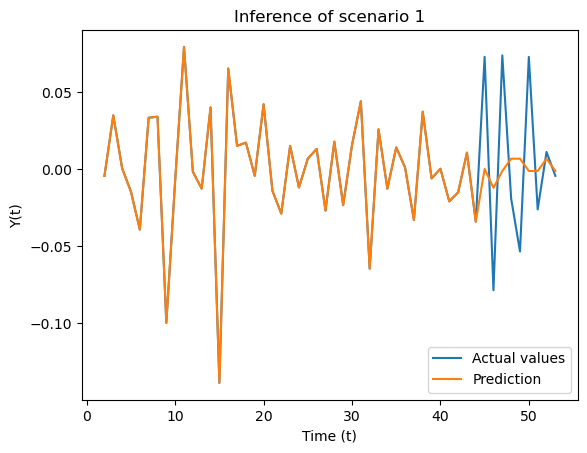

In [42]:
# get sequences for comparison
past_seq = df_stationary[(df_stationary.country == test_country)
                         & (df_stationary.year <= split_year)].energy_cons_stationary.to_list()
all_pred_seq = np.array(past_seq + pred_seq[1:]) 
all_actual_seq = np.array(past_seq + actual_seq)

nb_points = all_actual_seq.shape[0]
x_ = pd.unique(df_stationary.year)
print(len(x_), all_pred_seq.shape[0], len(past_seq))

# get curves on a sampe plot
plt.plot(np.arange(nb_points), all_actual_seq, label="Actual values")
plt.plot(np.arange(nb_points), all_pred_seq, label="Prediction")

plt.title("Inference of scenario 1")
plt.xlabel("Time (t)")
plt.ylabel("Y(t)")
plt.legend()
plt.show()

In [43]:
def reconstruct_signal(pred, past):
    """
    """
    true_pred = np.zeros_like(pred, dtype=np.float32)
    for i, val in np.ndenumerate(pred):

        x, y = past[-2:]

        new_y = np.exp(val - np.log(x) + 2*np.log(y))
        true_pred[i] = new_y
        
        past = np.hstack([past, new_y])

    past_array = np.array(past)
    return past_array

# Comparison with ARIMA model

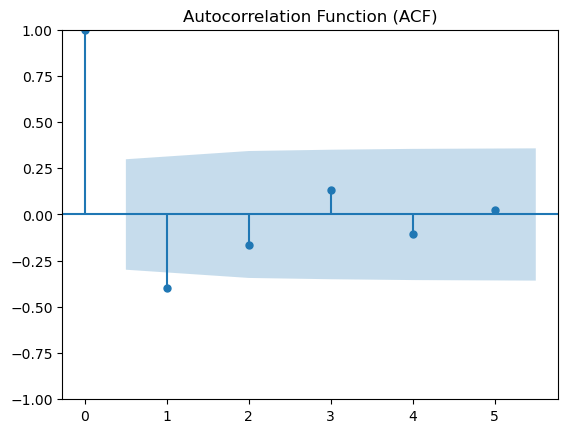

In [44]:
#
ts_stationary = df_stationary[df_stationary.country == test_country]
ts_stationary.set_index("year", inplace=True, drop=True)
ts_stationary = ts_stationary[["energy_cons_stationary"]]
ts_stationary.dropna(inplace=True)

plot_acf(ts_stationary[ts_stationary.index <= split_year], lags=5)
plt.title('Autocorrelation Function (ACF)')
plt.show()

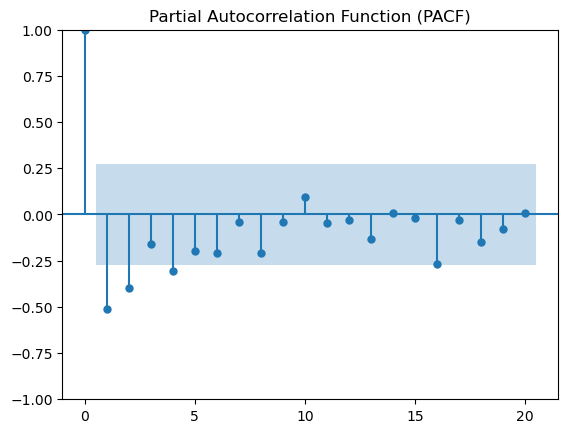

In [45]:
plot_pacf(ts_stationary[ts_stationary <= split_year], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [46]:
# Replace p, d, q values with the parameters determined from ACF and PACF plots
p = 1  # AR order
d = 0  # differencing order (set to 0 for stationary data)
q = 2  # MA order
model = ARIMA(ts_stationary[ts_stationary <= split_year], order=(p, d, q))
results = model.fit()

# Summary of the ARIMA model
print(results.summary())

# Forecast future values
forecast_steps = length  # Number of steps ahead to forecast
forecast = results.forecast(steps=forecast_steps)

ts_stationary["pred_arima"] = list(ts_stationary[ts_stationary.index <= split_year].values) + list(forecast)

c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836

                                 SARIMAX Results                                  
Dep. Variable:     energy_cons_stationary   No. Observations:                   52
Model:                     ARIMA(1, 0, 2)   Log Likelihood                 110.189
Date:                    Sun, 14 Apr 2024   AIC                           -210.378
Time:                            18:10:53   BIC                           -200.622
Sample:                                 0   HQIC                          -206.638
                                     - 52                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.000     -1.082      0.279      -0.001       0.000
ar.L1         -0.9165      0.141     -6.520      0.000      -1.192      -0.641
ma.L1         -0.008

In [48]:
ts_stationary["pred_DBN"] = list(ts_stationary[ts_stationary.index <= split_year].energy_cons_stationary) + list(pred_seq[1:])

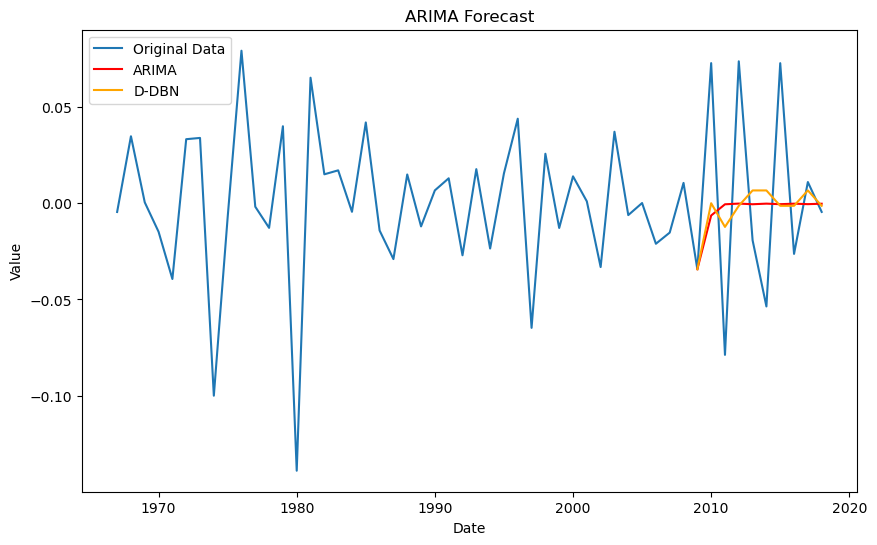

In [50]:
# Plot the original time series and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(ts_stationary.energy_cons_stationary, label='Original Data')
plt.plot(ts_stationary[ts_stationary.index >= split_year].pred_arima, label='ARIMA', color='red')
plt.plot(ts_stationary[ts_stationary.index >= split_year].pred_DBN, label='D-DBN', color='orange')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

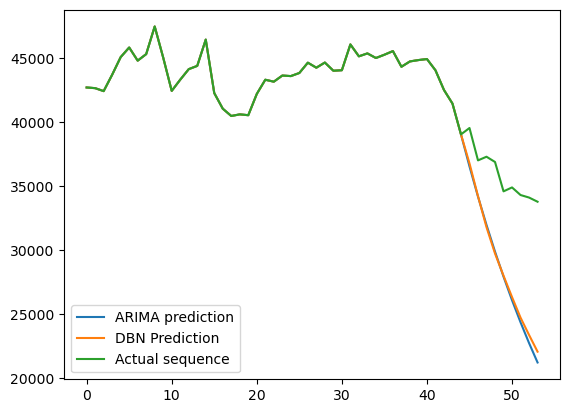

In [51]:
past_seq = list(data[(data.country == test_country)
                     & (data.year <= split_year)].energy_per_capita)
true_actual = data[(data.country == test_country)].energy_per_capita.to_numpy()

rec_actual = reconstruct_signal(actual_seq, past_seq)
true_pred_DBN = reconstruct_signal(pred_seq[1:], past_seq)
true_pred_ARIMA = reconstruct_signal(forecast, past_seq)

plt.plot(true_pred_ARIMA, label="ARIMA prediction")
plt.plot(true_pred_DBN, label="DBN Prediction")
plt.plot(true_actual, label="Actual sequence")

plt.legend()